In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from scipy.stats import randint, loguniform


In [112]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [113]:
dfs = []
for f in Path("data").iterdir():
    df = pd.read_csv(f)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [114]:
df = df[df["games_played"] == 82] 

In [115]:
df.shape

(2110, 109)

In [116]:
int_cols = df.select_dtypes(include="int64").columns.tolist()
int_cols

['season', 'games_played']

In [117]:
obj_cols = df.select_dtypes(include="object").columns.tolist()
obj_cols

['team', 'name', 'team.1', 'position', 'situation']

In [118]:
columns_to_drop = int_cols + obj_cols

In [119]:
df.to_csv("raw_data.csv", index=False)

In [120]:
df_x = pd.read_excel("lol.xlsx")    
df_x.to_csv("lol.csv", index=False)


In [121]:
df_pts = pd.read_csv("lol.csv")
df_pts.head()

,team,season,playoff
0,NYI,2009,0
1,ANA,2009,0
2,CGY,2009,0
3,EDM,2009,0
4,CBJ,2009,0


In [122]:
df = df.merge(
    df_pts, 
    on=["team", "season"],
    how="left"
)

In [123]:
missing_col = df.columns[df.isna().any()].tolist()
missing_col

['penaltiesFor', 'penaltiesAgainst', 'penalitiesFor', 'penalitiesAgainst']

In [124]:
columns_to_drop += missing_col
columns_to_drop

['season',
 'games_played',
 'team',
 'name',
 'team.1',
 'position',
 'situation',
 'penaltiesFor',
 'penaltiesAgainst',
 'penalitiesFor',
 'penalitiesAgainst']

In [125]:
df = df[df["situation"] == "all"] 

In [126]:
df = df.drop(columns=columns_to_drop)
df.head()

,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoff
1,0.50,0.48,0.49,300913.0,2466.97,238.16,172.96,545.72,81.21,1348.68,1056.27,228.49,238.01,228.35,2494.0,949.0,1182.0,4625.0,214.0,201.0,38.0,577.0,74.0,1047.0,1330.0,2280.0,3229.0,858.0,2261.0,1829.0,948.0,809.0,2521.0,684.0,238.0,74.34,82.03,81.79,79.0,65.0,70.0,4610.42,3443.0,3439.86,407.0,38.45,45.78,47.23,229.38,229.45,223.40,2578.49,242.24,181.31,573.57,84.06,1446.29,1110.53,231.91,243.26,232.90,2619.0,1019.0,1379.0,5017.0,258.0,166.0,41.0,660.0,99.0,1161.0,1294.0,2361.0,3380.0,919.0,2426.0,1872.0,833.0,826.0,2678.0,736.0,224.0,78.52,87.20,76.53,92.0,84.0,82.0,5040.57,3638.0,3650.78,398.0,40.28,38.07,40.25,242.28,243.11,235.81,0
6,0.46,0.48,0.47,299752.0,2342.95,218.89,161.52,513.90,75.09,1313.28,1009.26,211.93,219.20,212.23,2471.0,949.0,941.0,4361.0,233.0,162.0,43.0,530.0,68.0,1081.0,1346.0,2238.0,3187.0,1187.0,2187.0,2050.0,447.0,633.0,2624.0,625.0,171.0,83.32,75.26,60.31,82.0,80.0,71.0,4374.69,3420.0,3423.45,276.0,36.01,31.55,31.89,214.60,215.12,210.31,2622.30,259.16,182.73,577.49,86.50,1488.61,1088.63,243.45,259.47,243.73,2737.0,1091.0,943.0,4771.0,243.0,203.0,39.0,551.0,73.0,1266.0,1492.0,2494.0,3585.0,1123.0,2363.0,1763.0,548.0,661.0,2887.0,717.0,224.0,92.36,85.79,81.00,89.0,76.0,78.0,4761.74,3828.0,3822.06,326.0,40.81,45.50,47.18,243.46,243.09,235.24,0
11,0.50,0.51,0.50,298794.0,2379.63,201.14,156.39,544.08,75.75,1331.73,1013.27,194.96,202.33,196.15,2351.0,1005.0,1216.0,4572.0,201.0,133.0,31.0,529.0,66.0,1023.0,1404.0,2150.0,3155.0,1079.0,2237.0,1708.0,580.0,724.0,2666.0,507.0,183.0,73.96,62.47,64.70,80.0,57.0,64.0,4596.88,3356.0,3375.81,387.0,34.31,30.75,32.21,200.95,201.88,197.52,2344.66,203.81,158.95,533.19,76.85,1330.33,994.68,195.86,203.29,195.33,2372.0,966.0,1062.0,4400.0,203.0,160.0,43.0,506.0,77.0,1088.0,1304.0,2169.0,3135.0,1007.0,2424.0,1609.0,544.0,732.0,2605.0,555.0,178.

In [127]:
df.to_csv("starting_data.csv", index=False)

In [128]:
train_df, test_df = train_test_split(df)

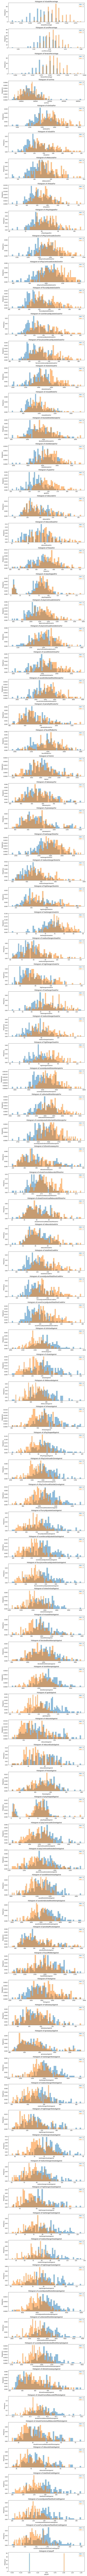

In [129]:
fig, axes = plt.subplots(nrows=len(train_df.columns.tolist()), ncols=1, figsize=(10, 3*len(train_df.columns.tolist())))

for i, c in enumerate(train_df.columns.tolist()):
    train_df.groupby("playoff")[c].plot.hist(
        bins=50,
        alpha=0.5, 
        legend=True, 
        density=True, 
        ax=axes[i]
    )
    
    axes[i].set_title(f"Histogram of {c}")
    axes[i].set_xlabel(c)

plt.tight_layout()
plt.show()

In [130]:
v2_cols_to_del = ["iceTime",
                   "reboundsFor",
                   "reboundGoalsFor",
                   "playStoppedFor",
                   "playContinuedOutsideZoneFor",
                   "penalityMinutesFor",
                   "faceOffsWonFor",
                   "hitsFor",
                   "takeawaysFor",
                   "giveawaysFor",
                   "highDangerShotsFor",
                   "highDangerxGoalsFor",
                   "dZoneGiveawaysFor",
                   "xGoalsFromActualReboundsOfShotsFor",
                   "reboundxGoalsFor",
                   "blockedShotAttemptsAgainst",
                   "reboundsAgainst",
                   "reboundGoalsAgainst",
                   "freezeAgainst",
                   "playStoppedAgainst",
                   "penalityMinutesAgainst",
                   "faceOffsWonAgainst",
                   "hitsAgainst",
		           "takeawaysAgainst",
                   "giveawaysAgainst",
                   "highDangerShotsAgainst",
                   "highDangerxGoalsAgainst",
                   "dZoneGiveawaysAgainst",
                   "xGoalsFromxReboundsOfShotsAgainst",
                   "xGoalsFromActualReboundsOfShotsAgainst",
                   "reboundxGoalsAgainst"]

In [131]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 1391 to 156
Data columns (total 99 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   xGoalsPercentage                           316 non-null    float64
 1   corsiPercentage                            316 non-null    float64
 2   fenwickPercentage                          316 non-null    float64
 3   iceTime                                    316 non-null    float64
 4   xOnGoalFor                                 316 non-null    float64
 5   xGoalsFor                                  316 non-null    float64
 6   xReboundsFor                               316 non-null    float64
 7   xFreezeFor                                 316 non-null    float64
 8   xPlayStoppedFor                            316 non-null    float64
 9   xPlayContinuedInZoneFor                    316 non-null    float64
 10  xPlayContinuedOutsideZoneFor

In [132]:
cols = train_df.columns.tolist()
print(len(cols))
cols = [c for c in cols if c not in v2_cols_to_del]
print(len(cols))
print(len(v2_cols_to_del))

99
68
31


In [133]:
X_train = train_df[cols]
X_train = X_train.drop(columns=["playoff"])
y_train = train_df.loc[:, "playoff"]

X_test = test_df[cols]
X_test = X_test.drop(columns=["playoff"])
y_test = test_df.loc[:, "playoff"]

In [134]:
dummy = DummyClassifier()
dummy_df = pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=5, return_train_score=True))
dummy_df

,fit_time,score_time,test_score,train_score
0,0.001252,0.000574,0.515625,0.511905
1,0.000559,0.000486,0.507937,0.513834
2,0.000451,0.000400,0.507937,0.513834
3,0.000955,0.000698,0.507937,0.513834
4,0.000442,0.000397,0.523810,0.509881


In [135]:
X_train.isna().any().any()

np.False_

In [136]:
numeric_transformer = StandardScaler()

In [137]:
len(cols)==X_train.shape[1]==X_test.shape[1]

False

In [138]:
cols.remove("playoff")
len(cols)==X_train.shape[1]==X_test.shape[1]

True

In [139]:
len(cols)==X_train.shape[1]==X_test.shape[1]

True

In [140]:
preprocessor = make_column_transformer(
    (
        numeric_transformer,
        cols
    )
)

In [141]:
models = {
    "decision_tree": DecisionTreeClassifier(),
    "knn": KNeighborsClassifier(),
    "rbf_svm": SVC(),
    "lr": LogisticRegression()
}

In [153]:
results = {}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    cv = cross_validate(pipe, X_train, y_train, return_train_score=True)
    
    result_dict = {}
    result_dict["train_mean"] = cv["train_score"].mean()
    for i, score in enumerate(cv["train_score"]):
        result_dict[f"train_fold{i+1}"] = score
    
    result_dict["test_mean"] = cv["test_score"].mean()
    
    for i, score in enumerate(cv["test_score"]):
        result_dict[f"test_fold{i+1}"] = score
    
    results[name] = result_dict
    
results_df = pd.DataFrame(results).T
results_df.sort_values("test_mean", ascending=False)

,train_mean,train_fold1,train_fold2,train_fold3,train_fold4,train_fold5,test_mean,test_fold1,test_fold2,test_fold3,test_fold4,test_fold5
lr,0.944614,0.936508,0.944664,0.948617,0.948617,0.944664,0.914633,0.890625,0.888889,0.920635,0.952381,0.920635
rbf_svm,0.935131,0.940476,0.936759,0.924901,0.936759,0.936759,0.873661,0.796875,0.888889,0.904762,0.888889,0.888889
decision_tree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.819792,0.765625,0.841270,0.888889,0.809524,0.793651
knn,0.880535,0.876984,0.869565,0.877470,0.889328,0.889328,0.813542,0.734375,0.857143,0.888889,0.793651,0.793651


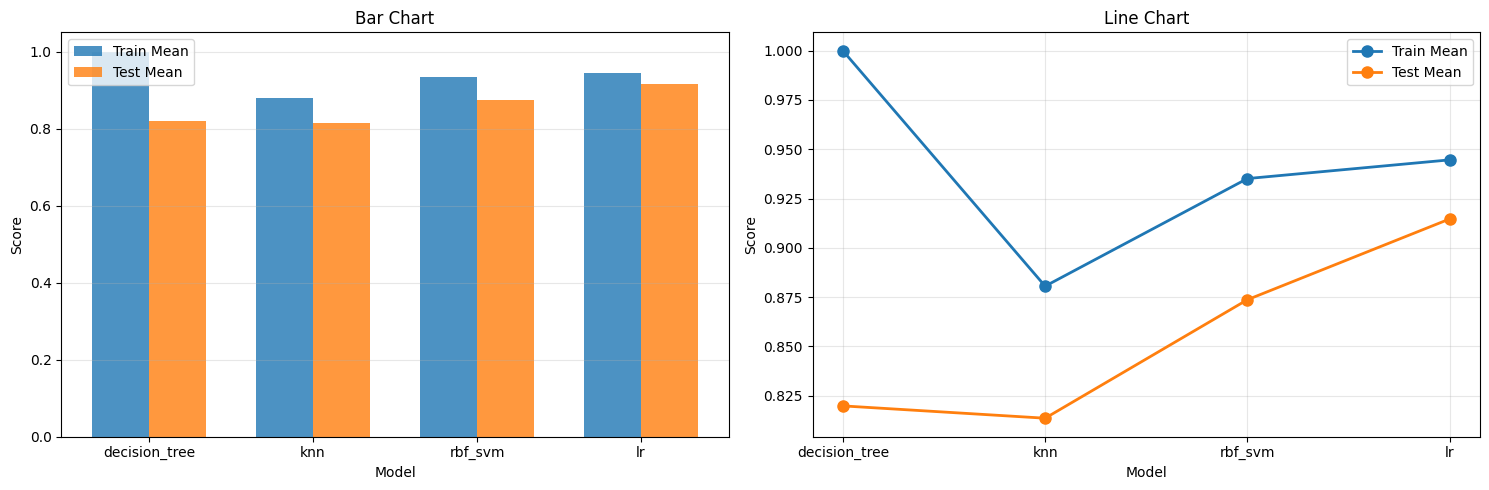

In [154]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart
x = range(len(results_df))
width = 0.35
ax1.bar([i - width/2 for i in x], results_df['train_mean'], width, label='Train Mean', alpha=0.8)
ax1.bar([i + width/2 for i in x], results_df['test_mean'], width, label='Test Mean', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('Score')
ax1.set_title('Bar Chart')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df.index)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Line chart
ax2.plot(results_df.index, results_df['train_mean'], marker='o', linewidth=2, markersize=8, label='Train Mean')
ax2.plot(results_df.index, results_df['test_mean'], marker='o', linewidth=2, markersize=8, label='Test Mean')
ax2.set_xlabel('Model')
ax2.set_ylabel('Score')
ax2.set_title('Line Chart')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [148]:
test_pipe = make_pipeline(preprocessor, LogisticRegression())

test_pipe.fit(X_train, y_train)
test_score = test_pipe.score(X_test, y_test)

In [149]:
test_score

0.8867924528301887

In [172]:
param_grid_dt = {
    "decisiontreeclassifier__max_depth": np.arange(3, 31)
}
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier())
grid_search_dt = GridSearchCV(pipe_dt, param_grid_dt, verbose=1, n_jobs=-1,) #grid search because small search space
grid_search_dt.fit(X_train, y_train)
pd.DataFrame(grid_search_dt.cv_results_)[["mean_test_score", "param_decisiontreeclassifier__max_depth", "mean_fit_time", "rank_test_score"]].set_index("rank_test_score").sort_index()

Fitting 5 folds for each of 28 candidates, totalling 140 fits


,mean_test_score,param_decisiontreeclassifier__max_depth,mean_fit_time
rank_test_score,,,
1,0.841915,3,0.007429
2,0.835565,17,0.010491
3,0.835516,8,0.016639
4,0.829365,23,0.011659
5,0.829315,19,0.010439
6,0.826240,11,0.016167
7,0.826141,4,0.009796
8,0.826091,12,0.009567
8,0.826091,28,0.012313


In [193]:
param_grid_knn = {
    "kneighborsclassifier__n_neighbors": np.arange(3, 31) #grid search because small search space
}
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())
grid_search_knn = GridSearchCV(pipe_knn, param_grid_knn, verbose=1, n_jobs=-1) #grid search because small search space
grid_search_knn.fit(X_train, y_train)
pd.DataFrame(grid_search_knn.cv_results_)[["mean_test_score", "param_kneighborsclassifier__n_neighbors", "mean_fit_time", "rank_test_score"]].set_index("rank_test_score").sort_index()

Fitting 5 folds for each of 28 candidates, totalling 140 fits


,mean_test_score,param_kneighborsclassifier__n_neighbors,mean_fit_time
rank_test_score,,,
1,0.826190,16,0.006826
2,0.823065,29,0.004582
3,0.822966,17,0.006043
4,0.819891,15,0.005061
5,0.816766,28,0.004740
6,0.816716,14,0.003368
7,0.816716,12,0.006425
7,0.816716,30,0.004020
9,0.813641,24,0.003764


In [211]:
param_grid_svc = {
    "svc__C": loguniform(1e-2, 1e3),
    "svc__gamma": loguniform(1e-4, 1e1)
}
pipe_svc = make_pipeline(preprocessor, SVC())
random_search_svc = RandomizedSearchCV(pipe_svc, param_grid_svc, n_iter=30, verbose=1, n_jobs=-1)
random_search_svc.fit(X_train, y_train)
pd.DataFrame(random_search_svc.cv_results_)[["mean_test_score", "param_svc__C", "param_svc__gamma", "mean_fit_time", "rank_test_score"]].set_index("rank_test_score").sort_index()

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,mean_test_score,param_svc__C,param_svc__gamma,mean_fit_time
rank_test_score,,,,
1,0.911458,35.501302,0.003097,0.006446
2,0.905109,85.388676,0.000141,0.005728
3,0.902083,14.722479,0.000908,0.008556
4,0.882986,6.497749,0.019066,0.008085
5,0.873611,10.863230,0.000163,0.006482
6,0.873512,554.842372,0.001623,0.006918
7,0.870337,134.734407,0.020898,0.007071
8,0.867163,70.296432,0.006266,0.006302
9,0.863988,62.525908,0.016543,0.006205


In [212]:
param_grid_lr = {
    "logisticregression__C": loguniform(1e-3, 1e3)
}
pipe_lr = make_pipeline(preprocessor, LogisticRegression())
random_search_lr = RandomizedSearchCV(pipe_lr, param_grid_lr, n_iter=30, verbose=1, n_jobs=-1) 
random_search_lr.fit(X_train, y_train)
pd.DataFrame(random_search_lr.cv_results_)[["mean_test_score", "param_logisticregression__C", "mean_fit_time", "rank_test_score"]].set_index("rank_test_score").sort_index()

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,mean_test_score,param_logisticregression__C,mean_fit_time
rank_test_score,,,
1,0.917857,0.220907,0.007621
1,0.917857,0.229597,0.007235
1,0.917857,0.191938,0.012809
4,0.914683,0.415941,0.008742
4,0.914683,0.430491,0.017801
4,0.914683,0.094585,0.010192
4,0.914683,0.122932,0.008943
8,0.914633,0.937519,0.014823
9,0.911508,0.163560,0.007106


In [213]:
best_C = 220907

In [215]:
pipe_final = make_pipeline(preprocessor, LogisticRegression(C=best_C, max_iter=1000)) # best model based on hyperparameter optimization, max_iter=1000 to avoid warning
pipe_final.fit(X_train, y_train)
test_score_final = pipe_final.score(X_test, y_test)

In [216]:
test_score_final

0.8679245283018868

this is worse than our logistic regression with no hyp opt... overfit, small dataset...